## Standard CycleGAN

#### 1. Github Connection

In [1]:
## install git and configure(so we know who commit the code)
# !apt-get install git
# !git config --global user.name "USER_NAME"
# !git config --global user.email "EMAIL"

# clone repo
!git clone https://github.com/Mu-niu13/Image-Translation-CycleGAN.git
%cd Image-Translation-CycleGAN

# set up personal access for push/pull
from getpass import getpass
token = getpass('Enter your GitHub PAT:')
!git remote set-url origin https://{token}@github.com/Mu-niu13/Image-Translation-CycleGAN.git

Cloning into 'Image-Translation-CycleGAN'...
remote: Enumerating objects: 1244, done.
remote: Counting objects: 100% (1244/1244), done.
remote: Compressing objects: 100% (1238/1238), done.
remote: Total 1244 (delta 12), reused 1215 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (1244/1244), 67.17 MiB | 15.78 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/Image-Translation-CycleGAN
Enter your GitHub PAT:··········


#### 2. Load Packages

In [2]:
!pip install torch_fidelity

import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import shutil

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch_fidelity import calculate_metrics
from tqdm import tqdm

#### 3. Utility Functions

In [3]:
def save_images_to_dir(images, directory):
    """Save a batch of images to the specified directory."""
    os.makedirs(directory, exist_ok=True)
    for i, img in enumerate(images):
        img_path = os.path.join(directory, f"image_{i}.png")
        img = (img * 0.5 + 0.5).clamp(0, 1)
        save_image(img, img_path)

def calculate_fid_and_inception(real_images, generated_images):
    """Calculate FID and Inception Score."""
    real_dir = "./temp/real_monet_images"
    fake_dir = "./temp/generated_images"

    # save images to directories
    save_images_to_dir(real_images, real_dir)
    save_images_to_dir(generated_images, fake_dir)

    # calculate metrics IS and FID
    metrics = calculate_metrics(
        input1=real_dir,
        input2=fake_dir,
        cuda=torch.cuda.is_available(),
        isc=True,  # Inception Score
        fid=True,  # FID
        verbose=False
    )

    # clean up temporary directories
    shutil.rmtree(real_dir)
    shutil.rmtree(fake_dir)

    return metrics

#### 4. Dataset and Model Architecture

In [4]:
# dataset
class MonetDataset(Dataset):
    def __init__(self, root, transform=None):
        self.files = glob.glob(os.path.join(root, '*.jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img



# residual layer
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.InstanceNorm2d(dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)



# progressive generator
# for each resolution stage add:
# - 1 downsample layer
# - 1 residual block
# - 1 upsample layer
# last resolution stays same due to limited computational resources

class ProgressiveGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, resolution, ngf=64):
        super(ProgressiveGenerator, self).__init__()
        # resolutions list
        res_list = [16, 32, 64, 128, 256, 512]
        stage = res_list.index(resolution) + 1

        # init block
        self.initial = nn.Sequential(
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=3),
            nn.InstanceNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # downsampling layers
        down_layers = []
        in_channels = ngf
        down = stage if stage < 6 else stage - 1
        for i in range(down):
            out_channels = in_channels * 2
            down_layers += [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            in_channels = out_channels
        self.down = nn.Sequential(*down_layers)

        # residual blocks
        res_layers = []
        for _ in range(stage):
            res_layers.append(ResidualBlock(in_channels))
        self.residual = nn.Sequential(*res_layers)

        # upsampling layers
        up_layers = []
        up = stage if stage < 6 else stage - 1
        for i in range(up):
            out_channels = in_channels // 2
            up_layers += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            in_channels = out_channels
        self.up = nn.Sequential(*up_layers)

        # final layer
        self.final = nn.Sequential(
            nn.Conv2d(in_channels, output_nc, kernel_size=7, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.down(x)
        x = self.residual(x)
        x = self.up(x)
        x = self.final(x)
        return x



# progressive discriminator
# <32x32: 2 layers
# <128x128: 3 layers
# >=128x128: 4 layers

class ProgressiveDiscriminator(nn.Module):
    def __init__(self, input_nc, resolution, ndf=64):
        super(ProgressiveDiscriminator, self).__init__()
        if resolution < 32:
            disc_layers = 2
        elif resolution < 128:
            disc_layers = 3
        else:
            disc_layers = 4

        layers = []
        # first layer
        layers.append(nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        # second layer
        if disc_layers > 1:
            layers.append(nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.InstanceNorm2d(ndf * 2))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

        # third layer
        if disc_layers > 2:
            layers.append(nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1))
            layers.append(nn.InstanceNorm2d(ndf * 4))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

        # fourth layer
        if disc_layers > 3:
            layers.append(nn.Conv2d(ndf * 4, 1, kernel_size=4, padding=1))
        else:
            # final prediction layer here
            final_in = ndf * (2 ** (disc_layers - 1))
            layers.append(nn.Conv2d(final_in, 1, kernel_size=4, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

#### 5. Loss Functions

In [5]:
# loss functions
def cycle_consistency_loss(x, reconstructed_x, lambda_cycle=10.0):
    return lambda_cycle * torch.mean(torch.abs(x - reconstructed_x))

def identity_loss(x, identity_x, lambda_identity=5.0):
    return lambda_identity * torch.mean(torch.abs(x - identity_x))

def gan_loss(pred, target_is_real=True):
    target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
    return torch.mean((pred - target)**2)

#### 6. Training Loop

Using device: cuda
=== Training at resolution 512x512 ===


100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


Extracting ./data/cifar/cifar-10-python.tar.gz to ./data/cifar


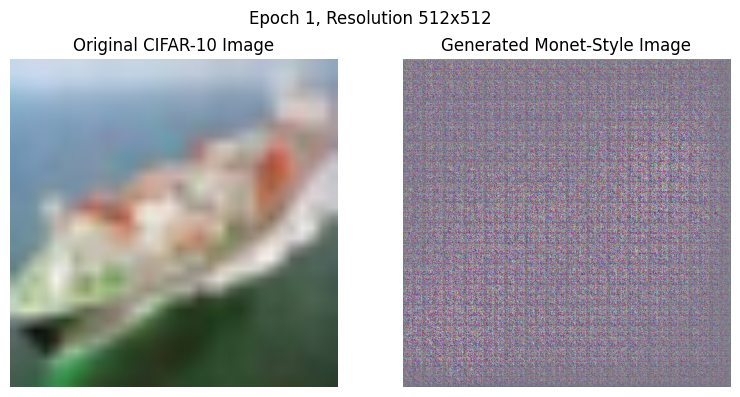

Epoch 1/15 | G Loss: 0.2243 | D Loss: 0.0120


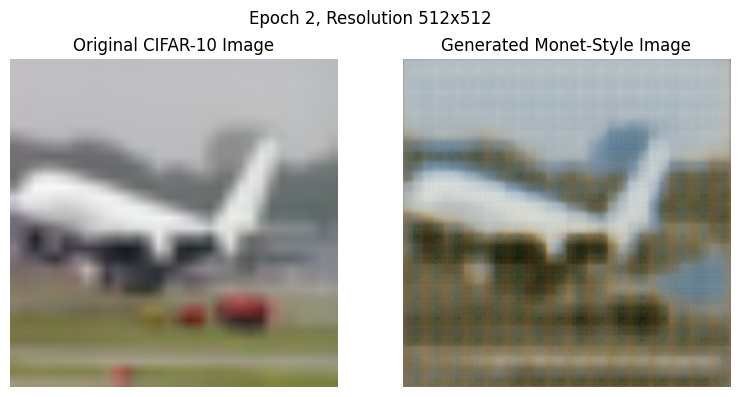

Epoch 2/15 | G Loss: 0.2054 | D Loss: 0.0101


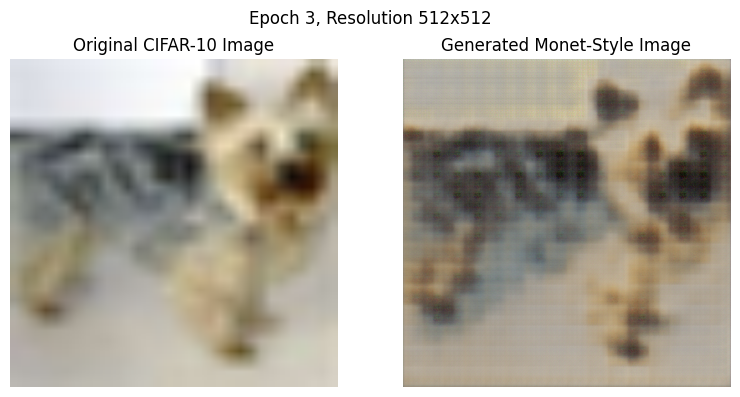

Epoch 3/15 | G Loss: 0.1949 | D Loss: 0.0097


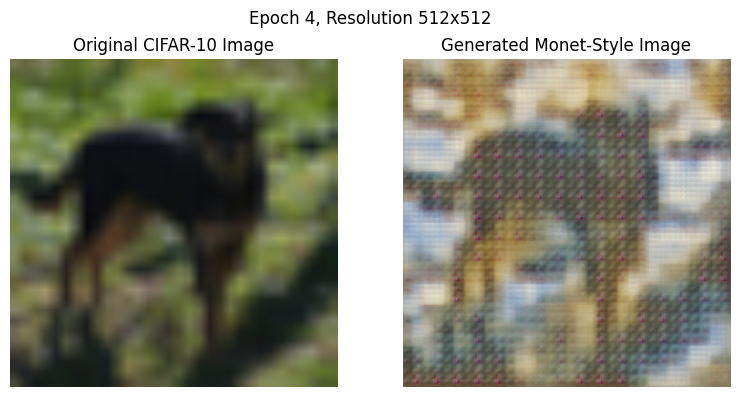

Epoch 4/15 | G Loss: 0.1853 | D Loss: 0.0097


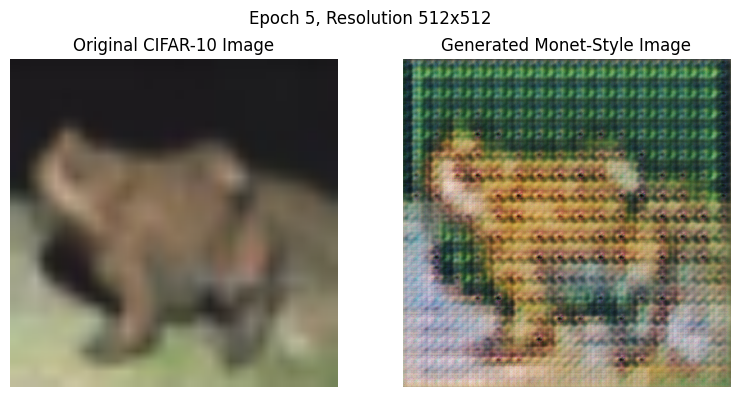

Epoch 5/15 | G Loss: 0.1738 | D Loss: 0.0099


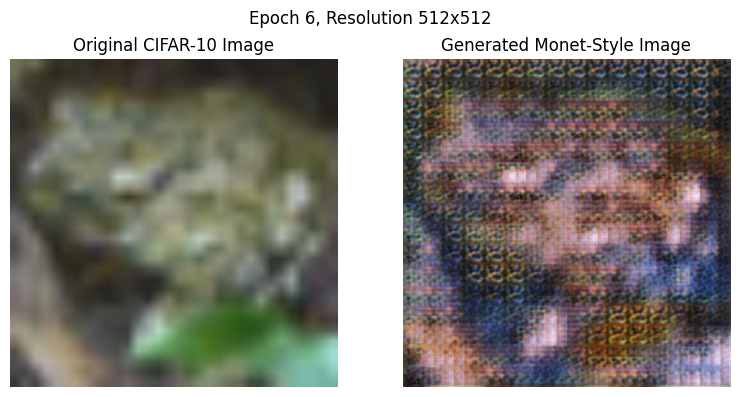

Epoch 6/15 | G Loss: 0.1616 | D Loss: 0.0099


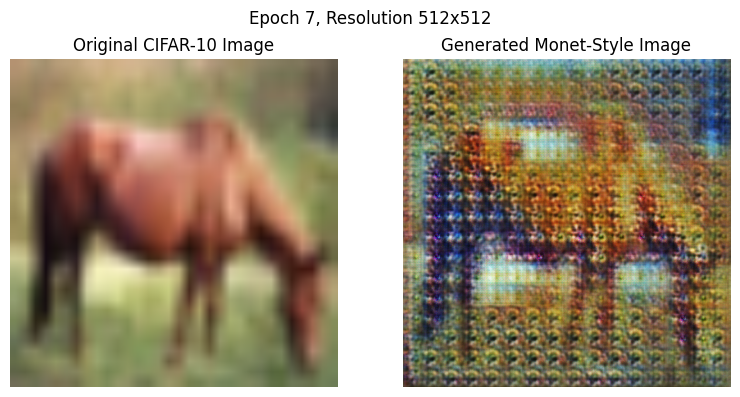

Epoch 7/15 | G Loss: 0.1541 | D Loss: 0.0099


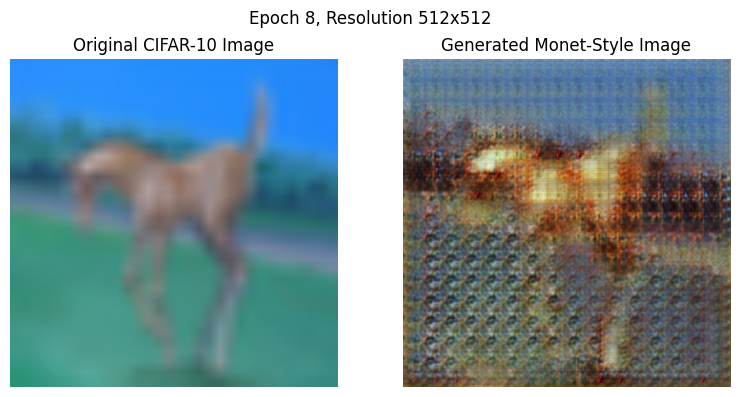

Epoch 8/15 | G Loss: 0.1495 | D Loss: 0.0099


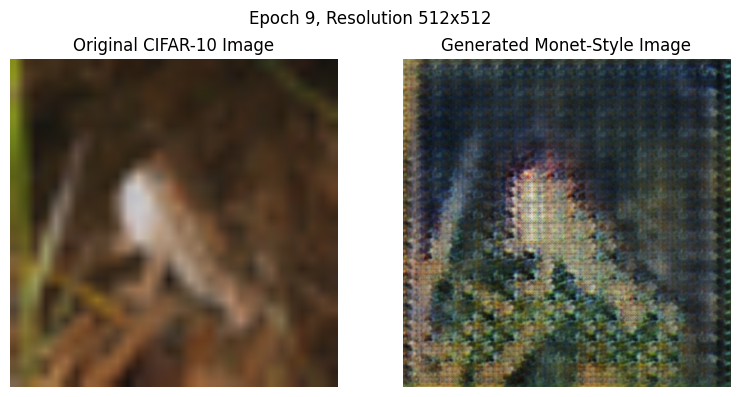

Epoch 9/15 | G Loss: 0.1437 | D Loss: 0.0100


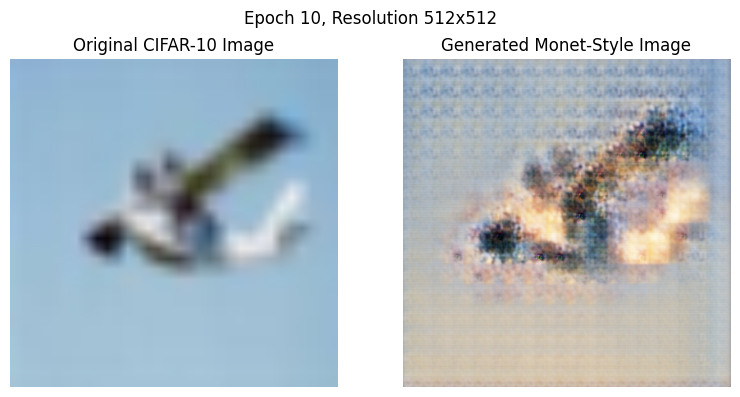

Epoch 10/15 | G Loss: 0.1388 | D Loss: 0.0099


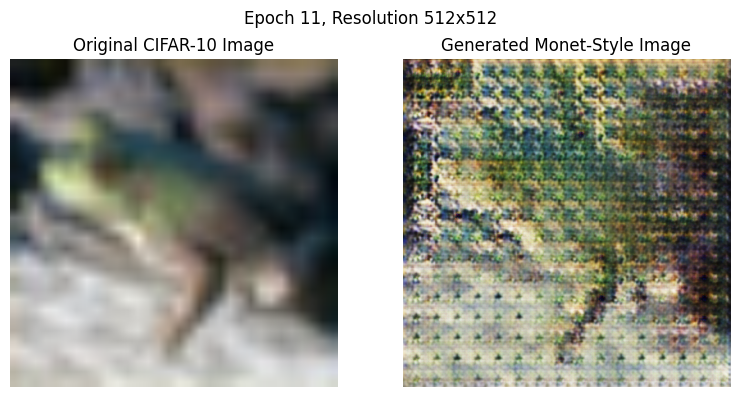

Epoch 11/15 | G Loss: 0.1370 | D Loss: 0.0098


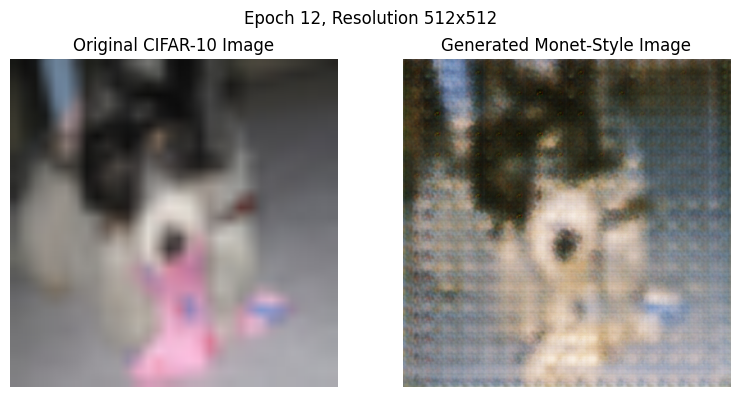

Epoch 12/15 | G Loss: 0.1344 | D Loss: 0.0100


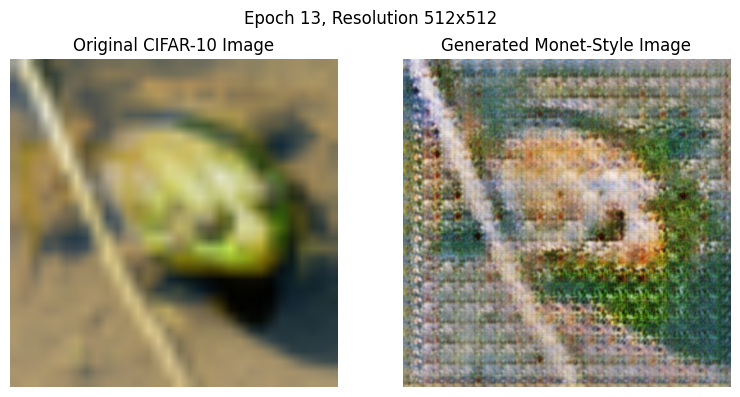

Epoch 13/15 | G Loss: 0.1323 | D Loss: 0.0097


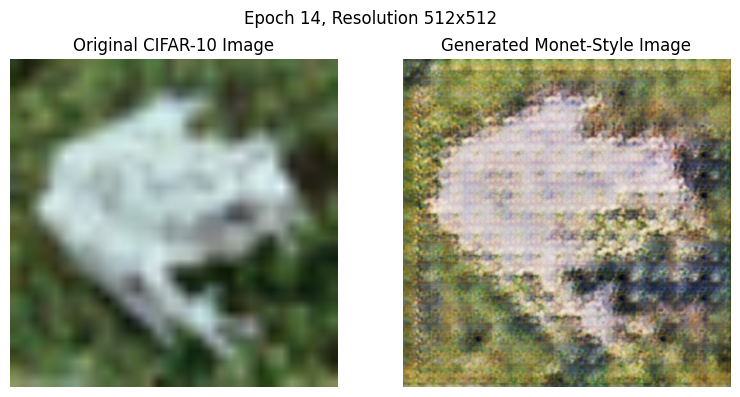

Epoch 14/15 | G Loss: 0.1318 | D Loss: 0.0095


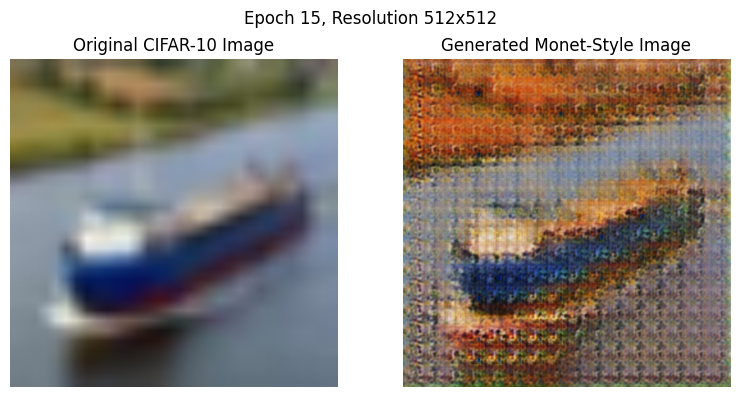

Epoch 15/15 | G Loss: 0.1317 | D Loss: 0.0089


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 32.4MB/s]
/usr/local/lib/python3.10/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


Metrics at Resolution 512x512:
FID: 273.0924
Inception Score: 4.4329


In [7]:
# main training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
print(f"Using device: {device}")


resolutions = [512]
epochs_per_stage = 15
lr = 0.0002
beta1, beta2 = 0.5, 0.999

lambda_cycle = 10
lambda_identity = 5

for resolution in resolutions:
    print(f"=== Training at resolution {resolution}x{resolution} ===")
    transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # adjust batch size for diff resolution
    if resolution <= 64:
        batch_size = 32
    elif resolution <= 256:
        batch_size = 16
    else:
        batch_size = 4

    # load CIFAR-10 and Monet datasets
    cifar_dataset = torchvision.datasets.CIFAR10(root='./data/cifar', train=True, download=True, transform=transform)
    monet_dataset = MonetDataset(root='./data/monet', transform=transform)

    cifar_loader = DataLoader(cifar_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
    monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

    # init models
    G_AtoB = ProgressiveGenerator(3, 3, resolution=resolution).to(device)
    G_BtoA = ProgressiveGenerator(3, 3, resolution=resolution).to(device)
    D_A = ProgressiveDiscriminator(3, resolution=resolution).to(device)
    D_B = ProgressiveDiscriminator(3, resolution=resolution).to(device)

    # optimizers
    optim_G = optim.Adam(list(G_AtoB.parameters()) + list(G_BtoA.parameters()), lr=lr, betas=(beta1, beta2))
    optim_D = optim.Adam(list(D_A.parameters()) + list(D_B.parameters()), lr=lr, betas=(beta1, beta2))

    for epoch in range(epochs_per_stage):
        G_AtoB.train()
        G_BtoA.train()
        D_A.train()
        D_B.train()

        epoch_loss_G = 0.0
        epoch_loss_D = 0.0

        for i, ((cifar_images, _), monet_images) in enumerate(zip(cifar_loader, monet_loader)):
            cifar_images = cifar_images.to(device)
            monet_images = monet_images.to(device)

            # train generators
            optim_G.zero_grad()

            # monet->fake->monet cycle
            fake_monet = G_AtoB(cifar_images)      # cifar to monet
            cycle_cifar = G_BtoA(fake_monet)       # monet back to cifar

            # cifar->fake->cifar cycle
            fake_cifar = G_BtoA(monet_images)      # monet to cifar
            cycle_monet = G_AtoB(fake_cifar)       # cifar back to monet

            # identity passes
            identity_monet = G_AtoB(monet_images)  # monet through AtoB
            identity_cifar = G_BtoA(cifar_images)   # cifar through BtoA

            # generator loss
            loss_gan_AtoB = gan_loss(D_B(fake_monet), True)
            loss_gan_BtoA = gan_loss(D_A(fake_cifar), True)
            loss_cycle_A = cycle_consistency_loss(cifar_images, cycle_cifar, lambda_cycle)
            loss_cycle_B = cycle_consistency_loss(monet_images, cycle_monet, lambda_cycle)
            loss_identity_A = identity_loss(monet_images, identity_monet, lambda_identity)
            loss_identity_B = identity_loss(cifar_images, identity_cifar, lambda_identity)

            loss_G = (loss_gan_AtoB + loss_gan_BtoA + loss_cycle_A + loss_cycle_B
                      + loss_identity_A + loss_identity_B)
            loss_G.backward()
            optim_G.step()

            # train discriminators
            optim_D.zero_grad()

            fake_cifar_detached = fake_cifar.detach()
            fake_monet_detached = fake_monet.detach()

            # D_A
            pred_real_A = D_A(cifar_images)
            pred_fake_A = D_A(fake_cifar_detached)
            loss_D_A = (gan_loss(pred_real_A, True) + gan_loss(pred_fake_A, False)) * 0.5
            loss_D_A.backward(retain_graph=True)

            # D_B
            pred_real_B = D_B(monet_images)
            pred_fake_B = D_B(fake_monet_detached)
            loss_D_B = (gan_loss(pred_real_B, True) + gan_loss(pred_fake_B, False)) * 0.5
            loss_D_B.backward()

            optim_D.step()

            loss_D = loss_D_A + loss_D_B

            epoch_loss_G += loss_G.item()
            epoch_loss_D += loss_D.item()

            # show 1 image pair
            if i == 0:
                def denormalize(img):
                    return img * 0.5 + 0.5

                original_image = cifar_images[0].detach().cpu()
                generated_image = fake_monet[0].detach().cpu()

                original_image = denormalize(original_image).permute(1, 2, 0).numpy()
                generated_image = denormalize(generated_image).permute(1, 2, 0).numpy()

                fig, axes = plt.subplots(1, 2, figsize=(8, 4))
                axes[0].imshow(np.clip(original_image, 0, 1))
                axes[0].set_title('Original CIFAR-10 Image')
                axes[0].axis('off')

                axes[1].imshow(np.clip(generated_image, 0, 1))
                axes[1].set_title('Generated Monet-Style Image')
                axes[1].axis('off')

                plt.suptitle(f"Epoch {epoch+1}, Resolution {resolution}x{resolution}")
                plt.tight_layout()
                plt.show()

            del fake_monet, fake_cifar, cycle_cifar, cycle_monet, identity_monet, identity_cifar
            torch.cuda.empty_cache()

        print(f"Epoch {epoch+1}/{epochs_per_stage} | G Loss: {epoch_loss_G/len(cifar_loader):.4f} | "
              f"D Loss: {epoch_loss_D/len(cifar_loader):.4f}")

    # get FID and IS
    G_AtoB.eval()
    required_samples = 320
    real_monet_images = []
    fake_monet_images = []

    monet_dataset = MonetDataset(root='./data/monet', transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
    monet_iter = iter(monet_loader)
    cifar_iter = iter(cifar_loader)
    with torch.no_grad():
        while len(real_monet_images) < required_samples and len(fake_monet_images) < required_samples:
            real_batch = next(monet_iter)
            cifar_batch, _ = next(cifar_iter)

            real_monet_images.append(real_batch)
            fake_batch = G_AtoB(cifar_batch.to(device)).detach().cpu()
            real_monet_images = [torch.cat(real_monet_images, dim=0)]
            fake_monet_images.append(fake_batch)
            fake_monet_images = [torch.cat(fake_monet_images, dim=0)]

            if real_monet_images[0].size(0) >= required_samples and fake_monet_images[0].size(0) >= required_samples:
                break

    real_monet_images = real_monet_images[0][:required_samples]
    fake_monet_images = fake_monet_images[0][:required_samples]

    metrics = calculate_fid_and_inception(real_monet_images, fake_monet_images)
    fid_score = metrics['frechet_inception_distance']
    inception_score = metrics['inception_score_mean']

    print(f"Metrics at Resolution {resolution}x{resolution}:")
    print(f"FID: {fid_score:.4f}")
    print(f"Inception Score: {inception_score:.4f}")

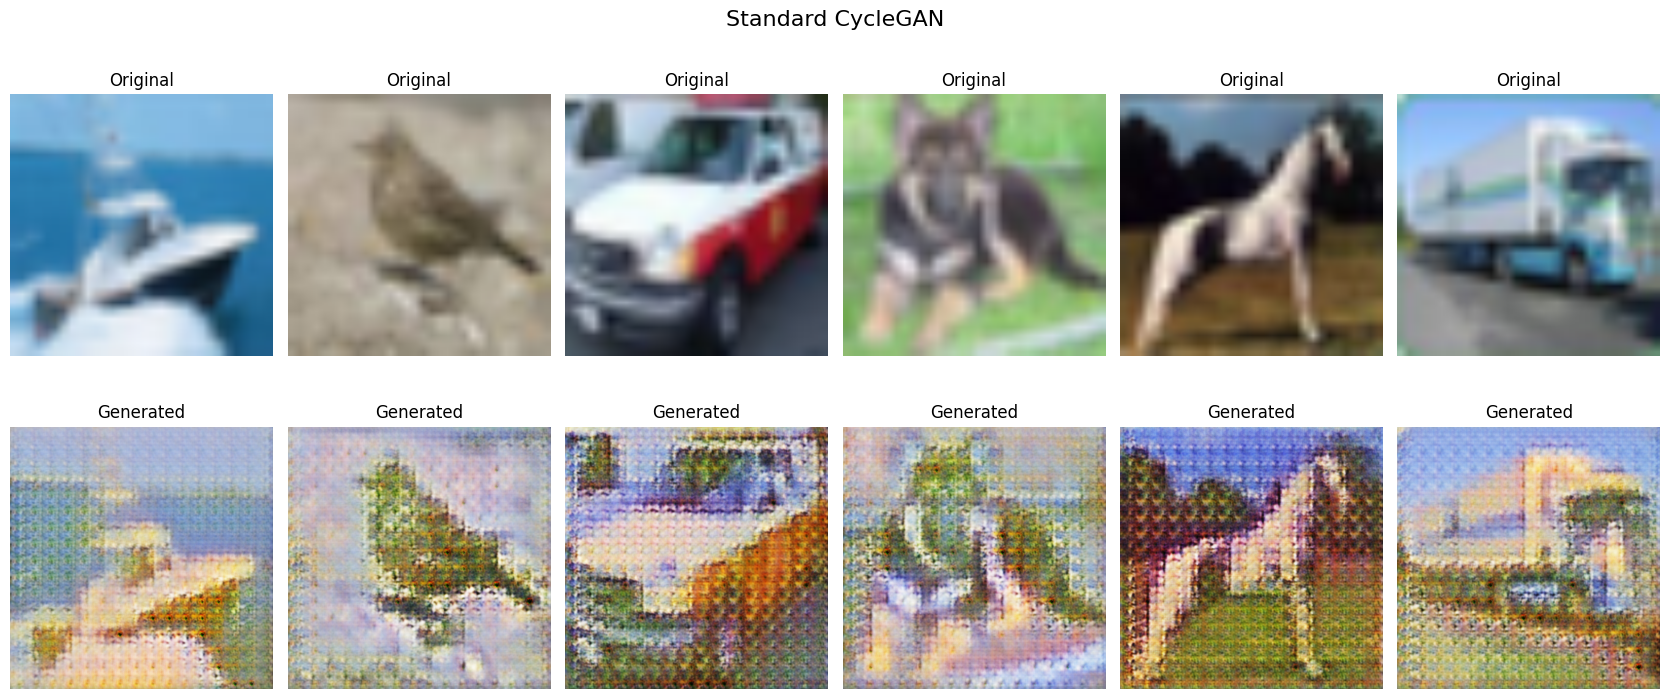

In [33]:
import numpy as np
import random
import matplotlib.pyplot as plt

def denormalize(img):
    return img * 0.5 + 0.5

# seed reproducibility
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

fixed_indices = [8, 120, 60, 156, 68, 109]

# load images
fixed_images = torch.stack([cifar_dataset[i][0] for i in fixed_indices])
fixed_images = fixed_images.to(device)

# generate corresponding images in monet style
G_AtoB.eval()
with torch.no_grad():
    generated_images = G_AtoB(fixed_images).cpu()

# display
fixed_images = denormalize(fixed_images.cpu())
generated_images = denormalize(generated_images)

# plot
num_images = 6
fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 8))
fig.suptitle("Standard CycleGAN", fontsize=16)

for i in range(num_images):
    # original image
    orig_ax = axes[0, i]
    orig_img = fixed_images[i].permute(1, 2, 0).clamp(0, 1).numpy()
    orig_ax.imshow(orig_img)
    orig_ax.set_title("Original")
    orig_ax.axis('off')

    # generated image
    gen_ax = axes[1, i]
    gen_img = generated_images[i].permute(1, 2, 0).clamp(0, 1).numpy()
    gen_ax.imshow(gen_img)
    gen_ax.set_title("Generated")
    gen_ax.axis('off')

plt.tight_layout(rect=[-0.2, 0, 1.2, 1.05])
plt.show()